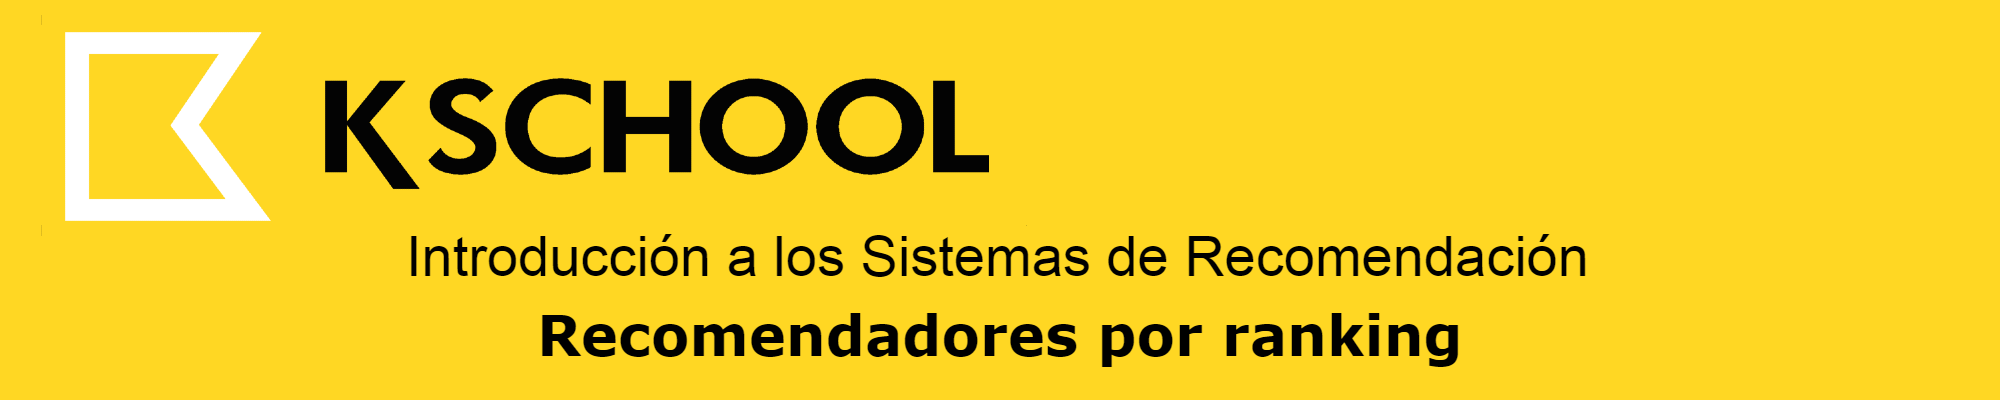

Hay empresas que realizan recomendaciones basándose en un simple ranking de sus productos de forma que, una vez obtenido éste, simplemente se recomiendan aquellos productos con valores más elevados. Sin embargo, un ranking basado simplemente en el valor medio de las notas recibidas de los usuarios -por ejemplo- puede no reflejar la verdadera opinión que los usuarios tienen de dicho producto.

En este apartado vamos a ver cómo elaboran sus rankings empresas tan importantes como <strong>IMDB</strong> o <strong>TripAdvisor</strong>.

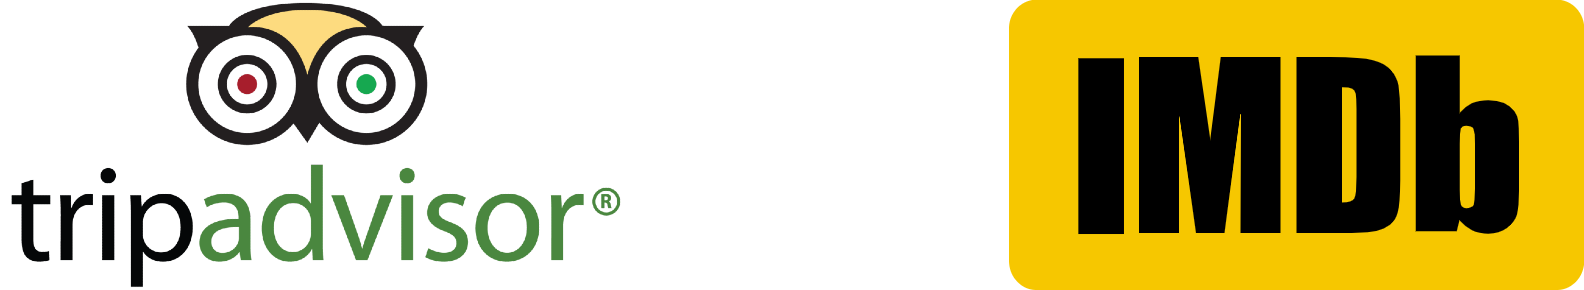

### Ranking ponderados

El hecho es que una métrica que no tenga en cuenta la popularidad de, por ejemplo, una película (si es que estamos hablando de películas) podría devolver resultados inesperados. Así, una película que haya recibido una calificación media de 9 puntos tras recibir 100 mil votos quedaría por detrás de otra que hubiese recibido una calificación media de 9.5 puntos tras recibir apenas 50 votos, lo que podría no representar el interés real de ambas pues esta última puede tratarse de una película de nicho o de una categoría muy específica y que, por lo tanto, no resulte tan atractiva al usuario medio como la primera.

A medida que aumenta el número de votos que recibe un elemento, su valoración media tiende a normalizarse, reflejando mejor la opinión general de los usuarios. Dicho con otras palabras: cuando el número de calificaciones es pequeño, la valoración media resulta menos fiable.

Una solución es ponderar la valoración media en función del número de votos que ha recibido el elemento en cuestión, y un buen ejemplo de este tipo de recomendadores es <strong>IMDB</strong>. Esta empresa aplica un ranking a todas las películas en función del resultado de la siguiente fórmula:

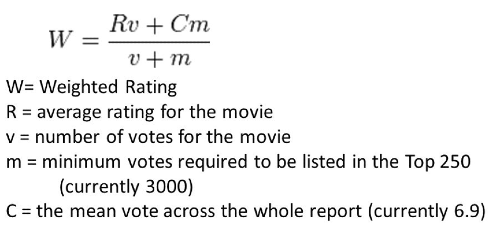

Además de la valoración media obtenida por una película (parámetro <strong>R</strong>), se considerar otros parámetros:
* <strong>v</strong>: Número de votos que ha recibido la película
* <strong>m</strong>: Número mínimo de votos que deberá haber recibido para ser considerada en el ranking
* <strong>C</strong>: Valoración media de todas las películas siendo consideradas

Todos estos parámetros son calculables a partir de los datos registrados por IMDB salvo el parámetro <strong>m</strong> (mínimo número de votos para ser considerada), parámetro cuya elección es arbitraria y que, por lo tanto, deberá ser considerado un <strong>hiperparámetro</strong> de nuestro algoritmo.

Carguemos ahora un par de librerías:

In [1]:
import pandas as pd
import os

In [2]:
names = lambda obj: print([name for name in dir(obj) if name[0] != "_"])

# Lectura de los datos

### Datos de películas

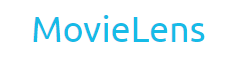

Para poner en práctica un recomendador tipo ranking, vamos a trabajar con el <strong>Full MovieLens Dataset</strong> que podemos descargar de la siguiente url:

https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset?select=movies_metadata.csv

Éste contiene información de 45 mil películas estrenadas hasta julio de 2017, incluyendo información sobre actores, presupuesto, doblajes, votos recibidos, etc.

En función de dónde hayamos almacenado el fichero csv que hemos descargado, deberemos modificar la siguiente variable para que apunte a dicha carpeta. En mi caso no tengo más que apuntar a la carpeta "data" que se encuentra en la carpeta actual (representada por el punto):

In [3]:
path = "./data/"

Leemos ahora el fichero usando la librería pandas:

In [4]:
movies = pd.read_csv(os.path.join(path, "movies_metadata.csv"), low_memory = False)

In [5]:
movies.shape

(45466, 24)

Mostremos los primeros registros:

In [6]:
movies.head(3)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0


Vamos a quedamos con el 10% de las películas más votadas. Calculemos el límite de votos que supone esto:

In [7]:
min_number_votes = movies.vote_count.quantile(0.90)
min_number_votes

160.0

Filtremos ahora nuestro dataset de forma que solo las películas que cumplan este requisito sean seleccionadas:

In [8]:
movies = movies.loc[movies.vote_count >= min_number_votes]

In [9]:
movies.shape

(4555, 24)

Ahora eliminamos películas cuya duración sea inferior a una hora o superior a tres (por ejemplo) para evitar que entren en el análisis miniseries, películas cortas o contenidos que no nos interesan:

In [10]:
movies = movies.loc[(movies.runtime >= 60) & (movies.runtime <= 180)]

In [11]:
movies.shape

(4484, 24)

Recordemos la fórmula de calificación:

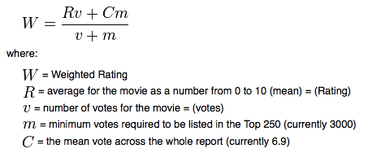

Calculemos el parámetro C (valoración media de todas las películas siendo consideradas):

In [12]:
mean_rating = movies.vote_average.mean()
mean_rating

6.457337198929528

Generemos la función W que calcula el ranking ponderado de forma que sea reutilizable:

In [13]:
def W(movie, m = min_number_votes, C = mean_rating):
    R = movie.vote_average
    v = movie.vote_count
    return ((R * v) + (C * m)) / (v + m)

Apliquemos nuestra fórmula, por ejemplo, a la primera película que aparece en el dataset. Veamos, en primer lugar, la película de que se trata:

In [14]:
movies[["title", "runtime", "vote_average", "vote_count"]].iloc[[0]]

,title,runtime,vote_average,vote_count
0,Toy Story,81.0,7.7,5415.0


Si aplicamos nuestra función a esta película...

In [15]:
W(movies.iloc[0])

7.6643361348571695

...vemos que el resultado de nuestra función no coincide con el valor medio de las valoraciones que ha recibido.

Apliquemos nuestra función a todo el dataframe "<i>movies</i>" y almacenemos el resultado en una nueva columna a la que podemos dar el nombre de "<i>score</i>":

In [16]:
movies["score"] = movies.apply(W, axis = 1)

In [17]:
movies.head(3)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,score
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,7.664336
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,6.872473
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0,6.063886


Ahora, para hacer una recomendación, basta con ordenar el dataframe según los valores de la columna recién creada:

In [18]:
movies = movies.sort_values(by = "score", ascending = False)
movies[["title", "runtime", "vote_count", "vote_average", "score"]].head(10)

,title,runtime,vote_count,vote_average,score
314,The Shawshank Redemption,142.0,8358.0,8.5,8.461631
834,The Godfather,175.0,6024.0,8.5,8.447150
12481,The Dark Knight,152.0,12269.0,8.3,8.276279
2843,Fight Club,139.0,9678.0,8.3,8.270032
292,Pulp Fiction,154.0,8670.0,8.3,8.266611
23673,Whiplash,105.0,4376.0,8.3,8.235003
5481,Spirited Away,125.0,3968.0,8.3,8.228579
40251,Your Name.,106.0,1030.0,8.5,8.225356
2211,Life Is Beautiful,116.0,3643.0,8.3,8.222475
1152,One Flew Over the Cuckoo's Nest,133.0,3001.0,8.3,8.206730


Obviamente, este enfoque no tiene en cuenta el usuario al que se hace la recomendación, pues el ranking es único.